In [53]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, UpSampling2D, Dense, MaxPool2D, LeakyReLU, Reshape, Dropout, Flatten, GaussianNoise
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import time

In [3]:
# df = pd.read_csv('./CUB_200_2011/CUB_200_2011/images.txt', delim_whitespace=True, header=None)
# df = df.drop(0, 1)

In [4]:
# df.columns = ['path']

In [5]:
# df.path[0]

In [6]:
# df[['class', 'junk']] = df['path'].str.split('/', expand=True)

In [7]:
# df[['class_number', 'junk']] = df['class'].str.split('.', expand=True)

In [8]:
# df['image_number'] = df.index + 1

In [9]:
# df = df.drop('junk', 1)

In [2]:
def normalize_img(img):
    return (img - 127.5)/127.5

def unnormalize_img(img):
    return (img + 1.) / 2.

In [11]:
# train_datagen = ImageDataGenerator(preprocessing_function=normalize_img)

In [12]:
# train_generator = train_datagen.flow_from_dataframe(
#         dataframe=df,
#         directory='./CUB_200_2011/CUB_200_2011/images/',
#         x_col="path",
#         y_col="class_number",
#         target_size=(64, 64),
#         batch_size=32,
#         class_mode='categorical',
#         save_to_dir='./CUB_200_2011/CUB_200_2011/images-cleaned/')

In [13]:
# for cls in df['class'].unique():
#     path = './CUB_200_2011/CUB_200_2011/images-cleaned/' + str(cls)
#     if not os.path.exists(path):
#         os.makedirs(path)

In [14]:
# for cls in df['class'].unique():
#     path = './CUB_200_2011/CUB_200_2011/images-cleaned/' + str(cls)
#     train_generator = train_datagen.flow_from_dataframe(
#         dataframe=df,
#         directory='./CUB_200_2011/CUB_200_2011/images/',
#         x_col="path",
#         y_col="class",
#         target_size=(64, 64),
#         batch_size=100,
#         class_mode='categorical',
#         classes = [str(cls)],
#         save_to_dir=path)
#     train_generator.next()

In [3]:
train_imgs = []
import os
for root, dirs, files in os.walk("./CUB_200_2011/CUB_200_2011/images-cleaned/", topdown=False):
    for name in files:
        train_imgs.append(cv2.cvtColor(cv2.imread(os.path.join(root, name)), cv2.COLOR_RGB2BGR))

train_imgs = np.array(train_imgs)
train_imgs = (train_imgs - 127.5)/127.5

In [4]:
def make_generator_model(shape):
    
    input_layer = Input(shape=shape)
    
    x = Dense(16*16*64)(input_layer)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Reshape((16, 16, 64))(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(32, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = GaussianNoise(1)(x)
    x = Conv2DTranspose(16, (3, 3), strides=(1, 1), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    
    x = Conv2DTranspose(3, (3, 3), strides=(1, 1), padding='same', use_bias=False, activation='tanh')(x)
    
    return Model(input_layer, x)

In [5]:
generator = make_generator_model((200,))
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
dense (Dense)                (None, 16384)             3293184   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 64)        0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 32)        18432 

In [6]:
generator = make_generator_model((200,))

noise = np.random.normal(0, 1, 200)

generated_image = generator.predict(np.array([noise]))[0]
plt.imshow(unnormalize_img(generated_image), )

In [7]:
def make_discriminator_model():
    input_layer = Input((64, 64, 3))
    x = GaussianNoise(1)(input_layer)
    
    x = Conv2D(64, (3, 3), strides=(2, 2), padding='same')(input_layer)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(64, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    
    x = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=(1, 1), padding='same')(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    
    
    x = Flatten()(x)
    x = Dense(64)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)
    x = Dense(1)(x)
    
    return Model(input_layer, x)

In [8]:
discriminator = make_discriminator_model()
discriminator.summary()
decision = discriminator.predict(np.array([generated_image]))
print (decision)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 64)        0   

In [9]:
cross_entropy = BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * tf.constant(0.9), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

In [12]:
@tf.function
def train_step(images):
#     noise = tf.random.normal([32, 200])
    noise = tf.random.truncated_normal([32, 200])
    
    gen_losses = []
    disc_losses = []

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        gen_losses.append(K.mean(gen_loss))
        disc_losses.append(K.mean(disc_loss))

#     do_train = sum(disc_losses)/len(disc_losses) > 0.
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
#     if do_train:
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        
    return (gen_losses, disc_losses)

In [13]:
def train(train_imgs, epochs):
    gen_loss_all = []
    disc_loss_all = []
    
    num_imgs = len(train_imgs)
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_epoch = [1, 0]
        disc_loss_epoch = [1, 0]
        
        np.random.shuffle(train_imgs)
        
        for i in range(0, num_imgs - 32, 32):
            gen_loss_batch, disc_loss_batch = train_step(train_imgs[i:(i+32)])

            gen_loss_epoch[0] += 1
            disc_loss_epoch[0] += 1
            gen_loss_epoch[1] += np.mean(gen_loss_batch)
            disc_loss_epoch[1] += np.mean(disc_loss_batch)
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        print(f'Gen loss: {gen_loss_epoch[1]/gen_loss_epoch[0]}, Disc loss: {disc_loss_epoch[1]/disc_loss_epoch[0]}')
        
        gen_loss_all.append(gen_loss_epoch[1]/gen_loss_epoch[0])
        disc_loss_all.append(disc_loss_epoch[1]/disc_loss_epoch[0])
    
    return (gen_loss_all, disc_loss_all)
    


In [14]:
discriminator = make_discriminator_model()
generator = make_generator_model((200,))
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Time for epoch 1 is 14.733404159545898 sec
Gen loss: 6.3991949054283825, Disc loss: 0.3899085267287929
Time for epoch 2 is 12.382850170135498 sec
Gen loss: 7.973224836959425, Disc loss: 0.3402537833545912
Time for epoch 3 is 12.375934362411499 sec
Gen loss: 7.959922479743234, Disc loss: 0.3519861380743787
Time for epoch 4 is 12.415235042572021 sec
Gen loss: 4.843310089292242, Disc loss: 0.46635276159942957
Time for epoch 5 is 12.439834356307983 sec
Gen loss: 4.989928924617406, Disc loss: 0.4251424084672

Time for epoch 74 is 12.662889003753662 sec
Gen loss: 4.621985123409488, Disc loss: 0.4679743247788127
Time for epoch 75 is 12.866542339324951 sec
Gen loss: 4.7724029804632915, Disc loss: 0.4849325299747591
Time for epoch 76 is 12.689609289169312 sec
Gen loss: 4.501930371209535, Disc loss: 0.4931423382222814
Time for epoch 77 is 12.705272912979126 sec
Gen loss: 4.798811003444641, Disc loss: 0.48225240566866184
Time for epoch 78 is 12.84966778755188 sec
Gen loss: 4.719457051295252, Disc loss: 0.471578211480686
Time for epoch 79 is 12.77448582649231 sec
Gen loss: 4.623816284706922, Disc loss: 0.474433041038875
Time for epoch 80 is 13.10871958732605 sec
Gen loss: 4.4264324015072045, Disc loss: 0.4818340401823928
Time for epoch 81 is 13.398114681243896 sec
Gen loss: 4.649219612442058, Disc loss: 0.46131042122517824
Time for epoch 82 is 13.381612300872803 sec
Gen loss: 4.962065312274427, Disc loss: 0.47210800922336943
Time for epoch 83 is 13.622938632965088 sec
Gen loss: 4.734859096971631, 

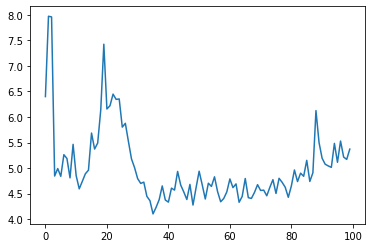

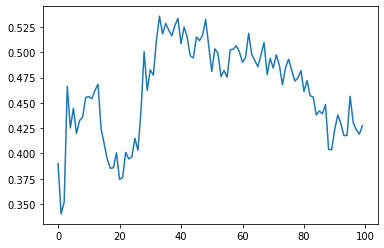

In [27]:
gen_hist, disc_hist = train(train_imgs, 100)

plt.plot(gen_hist)
plt.show()

plt.plot(disc_hist)
plt.show()

In [ ]:
def long_train(starting_epoch=0, num_epochs=0, checkpoint_interval=0, g_hist=None, d_hist=None, noise=None):
    
    if noise is None:
        noise = np.random.normal(0, 1, 200)

    if g_hist is None:
        g_hist = []
    
    if d_hist is None:
        d_hist = []

    for i in range(30, 40):
        gen_temp, disc_temp = train(train_imgs, 100)
        g_hist += gen_temp
        d_hist += disc_temp
        generated_image = generator.predict(np.array([noise]))[0]
        plt.imshow(unnormalize_img(generated_image))
        plt.savefig('./results/prog-imgs/bird-gan-deeper/' + str((i+1)*100) + '.png')
        plt.show()
        generator.save_weights('./results/weights/bird-gan-deeper/gen_weights_deeper_' + str((i+1)*100) + '.h5')
        discriminator.save_weights('./results/weights/bird-gan-deeper/disc_weights_deeper_' + str((i+1)*100) + '.h5')

Time for epoch 1 is 13.253501892089844 sec
Gen loss: 3.6434495022626425, Disc loss: 0.5860084625602091
Time for epoch 2 is 13.204076290130615 sec
Gen loss: 3.694134228920872, Disc loss: 0.5846602202754033
Time for epoch 3 is 13.18651294708252 sec
Gen loss: 3.6676327510254816, Disc loss: 0.5861388262371384
Time for epoch 4 is 13.19613528251648 sec
Gen loss: 3.6598022287777123, Disc loss: 0.5839512774614783
Time for epoch 5 is 13.464483737945557 sec
Gen loss: 3.7251908985902946, Disc loss: 0.5762805232833718
Time for epoch 6 is 13.190864562988281 sec
Gen loss: 3.6305667326702333, Disc loss: 0.5859396028809432
Time for epoch 7 is 13.308464050292969 sec
Gen loss: 3.687107469977402, Disc loss: 0.5844359982627517
Time for epoch 8 is 13.205606460571289 sec
Gen loss: 3.690678935063887, Disc loss: 0.5854716303387308
Time for epoch 9 is 13.234200716018677 sec
Gen loss: 3.6597541276678482, Disc loss: 0.5835800911514417
Time for epoch 10 is 13.61007308959961 sec
Gen loss: 3.756727254810695, Disc l

Time for epoch 81 is 13.7395920753479 sec
Gen loss: 3.658453375343385, Disc loss: 0.5857313421522052
Time for epoch 82 is 13.481334447860718 sec
Gen loss: 3.6887832094983355, Disc loss: 0.5795877562951912
Time for epoch 83 is 13.268222332000732 sec
Gen loss: 3.684801533293272, Disc loss: 0.5839997772278824
Time for epoch 84 is 13.233374118804932 sec
Gen loss: 3.6444167509311582, Disc loss: 0.5849617852105035
Time for epoch 85 is 13.227338552474976 sec
Gen loss: 3.7051371158300053, Disc loss: 0.5834436362513359
Time for epoch 86 is 13.226149559020996 sec
Gen loss: 3.6374685551092876, Disc loss: 0.580853188587075
Time for epoch 87 is 13.218947649002075 sec
Gen loss: 3.657349185891914, Disc loss: 0.5876669485556077
Time for epoch 88 is 13.231667280197144 sec
Gen loss: 3.7034007785766105, Disc loss: 0.5780024767568118
Time for epoch 89 is 13.38498830795288 sec
Gen loss: 3.673799251153217, Disc loss: 0.5834885150759523
Time for epoch 90 is 13.381101131439209 sec
Gen loss: 3.6927880698103244

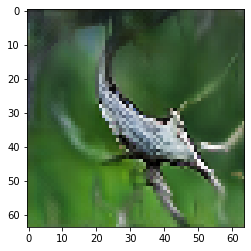

Time for epoch 1 is 13.272469758987427 sec
Gen loss: 3.6418202013827274, Disc loss: 0.5885433620876737
Time for epoch 2 is 13.224462509155273 sec
Gen loss: 3.6312914321093057, Disc loss: 0.5857348150515621
Time for epoch 3 is 13.232224225997925 sec
Gen loss: 3.7189319986638014, Disc loss: 0.5794921983386766
Time for epoch 4 is 13.222051858901978 sec
Gen loss: 3.661533725293994, Disc loss: 0.5846924948175425
Time for epoch 5 is 13.222933292388916 sec
Gen loss: 3.6724743784927742, Disc loss: 0.5813196281268991
Time for epoch 6 is 13.377541542053223 sec
Gen loss: 3.6321294831066595, Disc loss: 0.5855036547513512
Time for epoch 7 is 13.60819935798645 sec
Gen loss: 3.6614616963921525, Disc loss: 0.58511351343739
Time for epoch 8 is 13.539852857589722 sec
Gen loss: 3.688924003745805, Disc loss: 0.5812840368043439
Time for epoch 9 is 13.224916934967041 sec
Gen loss: 3.737014622546147, Disc loss: 0.58368398196652
Time for epoch 10 is 13.275976657867432 sec
Gen loss: 3.705207342054786, Disc los

Time for epoch 81 is 13.247522830963135 sec
Gen loss: 3.7004155724998413, Disc loss: 0.576938544993155
Time for epoch 82 is 13.287250995635986 sec
Gen loss: 3.6731553736740983, Disc loss: 0.5891946407191475
Time for epoch 83 is 13.239251136779785 sec
Gen loss: 3.6732764909584024, Disc loss: 0.5855733686023288
Time for epoch 84 is 13.521410703659058 sec
Gen loss: 3.665480972951667, Disc loss: 0.5831203476846379
Time for epoch 85 is 13.659239530563354 sec
Gen loss: 3.6278692829576613, Disc loss: 0.5871950940388005
Time for epoch 86 is 13.910930156707764 sec
Gen loss: 3.6902183213531163, Disc loss: 0.5800008966024652
Time for epoch 87 is 13.638917446136475 sec
Gen loss: 3.6590929587035967, Disc loss: 0.5841452123188391
Time for epoch 88 is 13.933336973190308 sec
Gen loss: 3.6902765491144445, Disc loss: 0.5878349870524109
Time for epoch 89 is 13.43697190284729 sec
Gen loss: 3.6915442859577294, Disc loss: 0.5808144308687225
Time for epoch 90 is 13.529800176620483 sec
Gen loss: 3.71245725691

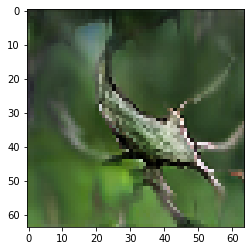

Time for epoch 1 is 13.229842901229858 sec
Gen loss: 3.640160695001039, Disc loss: 0.5851382730291464
Time for epoch 2 is 13.730519771575928 sec
Gen loss: 3.6738417626719486, Disc loss: 0.5851816910553754
Time for epoch 3 is 13.31929874420166 sec
Gen loss: 3.638796330144412, Disc loss: 0.587810816157478
Time for epoch 4 is 13.543343305587769 sec
Gen loss: 3.642035709164007, Disc loss: 0.5850199159729449
Time for epoch 5 is 13.28303861618042 sec
Gen loss: 3.6488246588202995, Disc loss: 0.592265191682309
Time for epoch 6 is 13.246336460113525 sec
Gen loss: 3.610912260970449, Disc loss: 0.587747816874729
Time for epoch 7 is 13.2515230178833 sec
Gen loss: 3.6033989181363486, Disc loss: 0.5914408244737764
Time for epoch 8 is 13.348464727401733 sec
Gen loss: 3.6697031650439835, Disc loss: 0.5838604403059011
Time for epoch 9 is 13.531188488006592 sec
Gen loss: 3.6310448381635876, Disc loss: 0.5884600632235932
Time for epoch 10 is 13.238563776016235 sec
Gen loss: 3.6665985396883998, Disc loss:

Time for epoch 81 is 13.235671520233154 sec
Gen loss: 3.647911656516677, Disc loss: 0.587691503892423
Time for epoch 82 is 13.231636047363281 sec
Gen loss: 3.630633571283604, Disc loss: 0.5847150294922878
Time for epoch 83 is 13.203819513320923 sec
Gen loss: 3.7100014990261254, Disc loss: 0.5898436177875291
Time for epoch 84 is 13.211853981018066 sec
Gen loss: 3.6552922984125815, Disc loss: 0.5787531279613009
Time for epoch 85 is 13.218472957611084 sec
Gen loss: 3.642019998736498, Disc loss: 0.5891661702940457
Time for epoch 86 is 13.2257399559021 sec
Gen loss: 3.641155761754933, Disc loss: 0.5893498592098877
Time for epoch 87 is 13.219390392303467 sec
Gen loss: 3.662378793809472, Disc loss: 0.5840265011076682
Time for epoch 88 is 13.217485904693604 sec
Gen loss: 3.6624784702207984, Disc loss: 0.584052102756371
Time for epoch 89 is 13.206284523010254 sec
Gen loss: 3.6559924323384356, Disc loss: 0.5856135913996192
Time for epoch 90 is 13.711051940917969 sec
Gen loss: 3.720855092614647, 

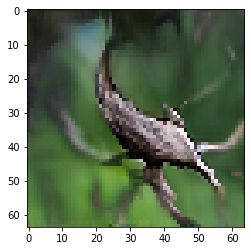

Time for epoch 1 is 13.222556114196777 sec
Gen loss: 3.7007931952230977, Disc loss: 0.589723390292346
Time for epoch 2 is 13.240581035614014 sec
Gen loss: 3.6222812076248125, Disc loss: 0.5888617222063587
Time for epoch 3 is 13.222069025039673 sec
Gen loss: 3.6379330539444923, Disc loss: 0.5897360065280584
Time for epoch 4 is 13.221019268035889 sec
Gen loss: 3.6473066696952676, Disc loss: 0.5845773819339307
Time for epoch 5 is 13.623706817626953 sec
Gen loss: 3.7104805543170714, Disc loss: 0.5792467267855719
Time for epoch 6 is 13.265694379806519 sec
Gen loss: 3.669545796505481, Disc loss: 0.5855544669841363
Time for epoch 7 is 13.278173208236694 sec
Gen loss: 3.6913416049667815, Disc loss: 0.5826502766227981
Time for epoch 8 is 13.956191301345825 sec
Gen loss: 3.6212124010411704, Disc loss: 0.5877527560645003
Time for epoch 9 is 13.801159143447876 sec
Gen loss: 3.710843051352152, Disc loss: 0.5806341357024382
Time for epoch 10 is 13.665854454040527 sec
Gen loss: 3.6965140521041744, Di

Time for epoch 81 is 13.253739833831787 sec
Gen loss: 3.6608197030013168, Disc loss: 0.5870462822397227
Time for epoch 82 is 13.248430252075195 sec
Gen loss: 3.7008564950327885, Disc loss: 0.5819353954740333
Time for epoch 83 is 13.21343994140625 sec
Gen loss: 3.6864951328856512, Disc loss: 0.5861780433473871
Time for epoch 84 is 13.232240438461304 sec
Gen loss: 3.6484952929220227, Disc loss: 0.589137743724394
Time for epoch 85 is 13.22715449333191 sec
Gen loss: 3.6340616989911085, Disc loss: 0.5863530373347161
Time for epoch 86 is 13.23724889755249 sec
Gen loss: 3.6157806701453397, Disc loss: 0.5941746558761856
Time for epoch 87 is 13.243314504623413 sec
Gen loss: 3.7202873578885707, Disc loss: 0.5826909409628974
Time for epoch 88 is 13.237223625183105 sec
Gen loss: 3.6113251024468482, Disc loss: 0.5928298171135146
Time for epoch 89 is 13.290521383285522 sec
Gen loss: 3.664253197388274, Disc loss: 0.5866761701862987
Time for epoch 90 is 13.22675609588623 sec
Gen loss: 3.59798044499343

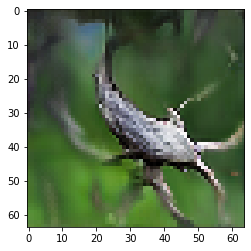

Time for epoch 1 is 13.676759004592896 sec
Gen loss: 3.594253105845878, Disc loss: 0.5922825606211737
Time for epoch 2 is 13.568390846252441 sec
Gen loss: 3.6757891559342384, Disc loss: 0.5842538818434325
Time for epoch 3 is 13.659341812133789 sec
Gen loss: 3.5779347322820647, Disc loss: 0.5929719427736794
Time for epoch 4 is 13.749689817428589 sec
Gen loss: 3.6264394227728287, Disc loss: 0.5881779785886366
Time for epoch 5 is 13.735473871231079 sec
Gen loss: 3.6594571091618318, Disc loss: 0.5839159744703349
Time for epoch 6 is 13.861658334732056 sec
Gen loss: 3.6962643664703783, Disc loss: 0.5858632859175767
Time for epoch 7 is 13.757160186767578 sec
Gen loss: 3.629443801838531, Disc loss: 0.5857242642217858
Time for epoch 8 is 13.70191216468811 sec
Gen loss: 3.61137794479122, Disc loss: 0.5910259841418848
Time for epoch 9 is 13.774985551834106 sec
Gen loss: 3.597315310785764, Disc loss: 0.5902163261159002
Time for epoch 10 is 13.38844633102417 sec
Gen loss: 3.6178980455165957, Disc l

Time for epoch 81 is 13.415390968322754 sec
Gen loss: 3.671338402481906, Disc loss: 0.5862972321226022
Time for epoch 82 is 13.74040412902832 sec
Gen loss: 3.636624970087191, Disc loss: 0.5894993985409982
Time for epoch 83 is 13.362727165222168 sec
Gen loss: 3.6170935643720754, Disc loss: 0.59195660107181
Time for epoch 84 is 13.434601068496704 sec
Gen loss: 3.6848057136949164, Disc loss: 0.5856963399302991
Time for epoch 85 is 13.493690490722656 sec
Gen loss: 3.6089140496602874, Disc loss: 0.5884854522177844
Time for epoch 86 is 13.819594144821167 sec
Gen loss: 3.671170076380577, Disc loss: 0.5845754787850832
Time for epoch 87 is 13.406566381454468 sec
Gen loss: 3.6524372417429274, Disc loss: 0.5871137223915679
Time for epoch 88 is 13.761652946472168 sec
Gen loss: 3.6665636905163606, Disc loss: 0.58588730562024
Time for epoch 89 is 14.020876169204712 sec
Gen loss: 3.6912162187622815, Disc loss: 0.5833357368219836
Time for epoch 90 is 13.395967483520508 sec
Gen loss: 3.646321999025216,

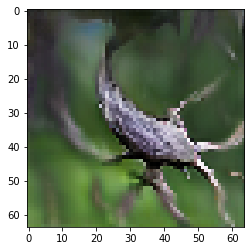

Time for epoch 1 is 14.824280977249146 sec
Gen loss: 3.6661510583831043, Disc loss: 0.5919442096861397
Time for epoch 2 is 14.719769954681396 sec
Gen loss: 3.6390701981417855, Disc loss: 0.5796212593552866
Time for epoch 3 is 13.391318082809448 sec
Gen loss: 3.7094597176807684, Disc loss: 0.5802077983776082
Time for epoch 4 is 13.402929782867432 sec
Gen loss: 3.7007764762010034, Disc loss: 0.5832740159700234
Time for epoch 5 is 13.218658924102783 sec
Gen loss: 3.6587483366007403, Disc loss: 0.5883111843087163
Time for epoch 6 is 13.363550901412964 sec
Gen loss: 3.696901188310246, Disc loss: 0.590874761019942
Time for epoch 7 is 13.686446905136108 sec
Gen loss: 3.5971273206436862, Disc loss: 0.5927062398857541
Time for epoch 8 is 13.42107367515564 sec
Gen loss: 3.6100029467244137, Disc loss: 0.588630758972995
Time for epoch 9 is 13.3365478515625 sec
Gen loss: 3.6191440559015042, Disc loss: 0.5879065836994306
Time for epoch 10 is 13.43012285232544 sec
Gen loss: 3.6182178436579098, Disc l

Time for epoch 81 is 14.054970979690552 sec
Gen loss: 3.6240742865616715, Disc loss: 0.5913943761409459
Time for epoch 82 is 13.812252044677734 sec
Gen loss: 3.622830256537047, Disc loss: 0.5923687878662978
Time for epoch 83 is 13.443879842758179 sec
Gen loss: 3.663418433853604, Disc loss: 0.5864288667191658
Time for epoch 84 is 13.57342267036438 sec
Gen loss: 3.6155606737627894, Disc loss: 0.592901247869016
Time for epoch 85 is 13.406718730926514 sec
Gen loss: 3.631311562003159, Disc loss: 0.5908960253404085
Time for epoch 86 is 13.321812152862549 sec
Gen loss: 3.589362008138724, Disc loss: 0.5921397177669091
Time for epoch 87 is 13.3205246925354 sec
Gen loss: 3.640480526740635, Disc loss: 0.5890589097166449
Time for epoch 88 is 13.348274946212769 sec
Gen loss: 3.6036030923124898, Disc loss: 0.5890758430893183
Time for epoch 89 is 13.590665817260742 sec
Gen loss: 3.6468372991091513, Disc loss: 0.5886092174667007
Time for epoch 90 is 13.581392049789429 sec
Gen loss: 3.684448852125545, 

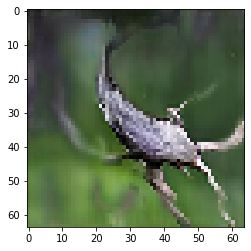

Time for epoch 1 is 13.216089963912964 sec
Gen loss: 3.625203713492003, Disc loss: 0.5897603531678518
Time for epoch 2 is 13.214739799499512 sec
Gen loss: 3.6267990006340876, Disc loss: 0.5928302621292229
Time for epoch 3 is 13.216596126556396 sec
Gen loss: 3.6568673975099393, Disc loss: 0.5899170810775705
Time for epoch 4 is 13.247756958007812 sec
Gen loss: 3.5647399677493707, Disc loss: 0.5960132698541089
Time for epoch 5 is 13.22538423538208 sec
Gen loss: 3.6527975548896685, Disc loss: 0.5882714468289197
Time for epoch 6 is 13.23067021369934 sec
Gen loss: 3.6399814068140377, Disc loss: 0.5904980829253106
Time for epoch 7 is 13.237857341766357 sec
Gen loss: 3.6462996296766326, Disc loss: 0.5868628848051314
Time for epoch 8 is 13.228516340255737 sec
Gen loss: 3.600726553418126, Disc loss: 0.5920309221679926
Time for epoch 9 is 13.27058458328247 sec
Gen loss: 3.6600897350931554, Disc loss: 0.5834023198945736
Time for epoch 10 is 13.232070684432983 sec
Gen loss: 3.6861993232716714, Disc

Time for epoch 81 is 13.225162267684937 sec
Gen loss: 3.665697146883502, Disc loss: 0.5905760698686771
Time for epoch 82 is 13.270895957946777 sec
Gen loss: 3.676220409915376, Disc loss: 0.5884412909103279
Time for epoch 83 is 13.214808940887451 sec
Gen loss: 3.590536010943777, Disc loss: 0.5915690960922861
Time for epoch 84 is 13.234237670898438 sec
Gen loss: 3.610115365284245, Disc loss: 0.5921521587423516
Time for epoch 85 is 13.228448867797852 sec
Gen loss: 3.6551499909501737, Disc loss: 0.587597995834945
Time for epoch 86 is 13.204226016998291 sec
Gen loss: 3.6304694798580677, Disc loss: 0.5914697250538079
Time for epoch 87 is 13.233752250671387 sec
Gen loss: 3.6850905831913314, Disc loss: 0.5844488793272313
Time for epoch 88 is 13.219985961914062 sec
Gen loss: 3.6595561840346833, Disc loss: 0.582516233610913
Time for epoch 89 is 13.22385573387146 sec
Gen loss: 3.6623429961320833, Disc loss: 0.5932947407731519
Time for epoch 90 is 13.238379716873169 sec
Gen loss: 3.605669308484085

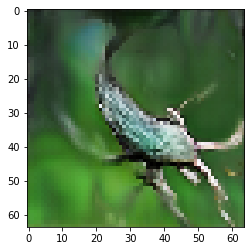

Time for epoch 1 is 13.235141038894653 sec
Gen loss: 3.619215164081191, Disc loss: 0.5883443116495602
Time for epoch 2 is 13.232141256332397 sec
Gen loss: 3.5832446991266598, Disc loss: 0.5940189737937638
Time for epoch 3 is 13.242015361785889 sec
Gen loss: 3.6395349631787637, Disc loss: 0.5886491185765925
Time for epoch 4 is 13.220231533050537 sec
Gen loss: 3.6408101685324983, Disc loss: 0.5894761511949989
Time for epoch 5 is 13.2243971824646 sec
Gen loss: 3.6594543469953664, Disc loss: 0.5847398631456422
Time for epoch 6 is 13.228693723678589 sec
Gen loss: 3.5862526402563906, Disc loss: 0.5978289488854447
Time for epoch 7 is 13.23412275314331 sec
Gen loss: 3.58873107181332, Disc loss: 0.5967194910456495
Time for epoch 8 is 13.226231813430786 sec
Gen loss: 3.6487099426548655, Disc loss: 0.5860590461469924
Time for epoch 9 is 13.271425485610962 sec
Gen loss: 3.608960040539584, Disc loss: 0.5926970553591968
Time for epoch 10 is 13.2232186794281 sec
Gen loss: 3.634375299541608, Disc loss

Time for epoch 81 is 13.278512001037598 sec
Gen loss: 3.6042429392899926, Disc loss: 0.5999420542057937
Time for epoch 82 is 13.240691661834717 sec
Gen loss: 3.6597857158681566, Disc loss: 0.5871931256317511
Time for epoch 83 is 13.218098878860474 sec
Gen loss: 3.6276873230611084, Disc loss: 0.5922283506813412
Time for epoch 84 is 13.223454236984253 sec
Gen loss: 3.672638977123147, Disc loss: 0.5840658660988175
Time for epoch 85 is 13.231081485748291 sec
Gen loss: 3.619721331247469, Disc loss: 0.5904424957789702
Time for epoch 86 is 13.220767974853516 sec
Gen loss: 3.624355782015214, Disc loss: 0.5911816723624542
Time for epoch 87 is 13.230193614959717 sec
Gen loss: 3.6495641208276517, Disc loss: 0.592317982337016
Time for epoch 88 is 13.22455906867981 sec
Gen loss: 3.6286391585176876, Disc loss: 0.5913954222105383
Time for epoch 89 is 13.22480297088623 sec
Gen loss: 3.6220258555115077, Disc loss: 0.5904487939223364
Time for epoch 90 is 13.287041187286377 sec
Gen loss: 3.60718949506599

Time for epoch 1 is 13.206453561782837 sec
Gen loss: 3.571667863747615, Disc loss: 0.5957664856258124
Time for epoch 2 is 13.207116603851318 sec
Gen loss: 3.630446096745933, Disc loss: 0.5884015456770817
Time for epoch 3 is 13.217338562011719 sec
Gen loss: 3.6343393629482446, Disc loss: 0.5922662946912978
Time for epoch 4 is 13.238995552062988 sec
Gen loss: 3.643693352133278, Disc loss: 0.5905093820437506
Time for epoch 5 is 13.22966194152832 sec
Gen loss: 3.627146573570686, Disc loss: 0.5975865550480561
Time for epoch 6 is 13.219125032424927 sec
Gen loss: 3.6408703333640164, Disc loss: 0.5881570467780922
Time for epoch 7 is 13.224079370498657 sec
Gen loss: 3.621003011377846, Disc loss: 0.5926660877579273
Time for epoch 8 is 13.26510500907898 sec
Gen loss: 3.5581746469668256, Disc loss: 0.6005547994843666
Time for epoch 9 is 13.2567458152771 sec
Gen loss: 3.626993272362686, Disc loss: 0.5901267982433805
Time for epoch 10 is 13.226374387741089 sec
Gen loss: 3.6425112598956764, Disc loss

Time for epoch 81 is 13.270648717880249 sec
Gen loss: 3.6124707812539283, Disc loss: 0.5970107224090959
Time for epoch 82 is 13.233778476715088 sec
Gen loss: 3.671206345726158, Disc loss: 0.5814474516606266
Time for epoch 83 is 13.224637031555176 sec
Gen loss: 3.627051764387425, Disc loss: 0.5941536945863791
Time for epoch 84 is 13.224497318267822 sec
Gen loss: 3.6422278551551384, Disc loss: 0.589656895738307
Time for epoch 85 is 13.217469453811646 sec
Gen loss: 3.657826297005341, Disc loss: 0.5911393856937647
Time for epoch 86 is 13.228457927703857 sec
Gen loss: 3.648053496833739, Disc loss: 0.592494603175781
Time for epoch 87 is 13.242911338806152 sec
Gen loss: 3.6128085796749043, Disc loss: 0.5910763742962504
Time for epoch 88 is 13.210133790969849 sec
Gen loss: 3.633904863502275, Disc loss: 0.5889003369704817
Time for epoch 89 is 13.229751586914062 sec
Gen loss: 3.6615949710856284, Disc loss: 0.5858227520938811
Time for epoch 90 is 13.26487112045288 sec
Gen loss: 3.654768374554187,

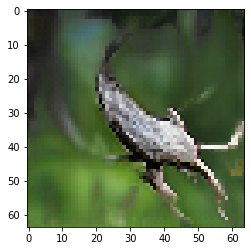

Time for epoch 1 is 13.213790655136108 sec
Gen loss: 3.6565063736303065, Disc loss: 0.5921566969333949
Time for epoch 2 is 13.229187488555908 sec
Gen loss: 3.5722352702443194, Disc loss: 0.5960522411153891
Time for epoch 3 is 13.243395566940308 sec
Gen loss: 3.604126248579361, Disc loss: 0.5901255060017594
Time for epoch 4 is 13.227979898452759 sec
Gen loss: 3.6454386704659396, Disc loss: 0.5907529252492961
Time for epoch 5 is 13.228686571121216 sec
Gen loss: 3.655976409834575, Disc loss: 0.5892001636790712
Time for epoch 6 is 13.225284099578857 sec
Gen loss: 3.7095549119520315, Disc loss: 0.5831761318978256
Time for epoch 7 is 13.226743221282959 sec
Gen loss: 3.60114532951417, Disc loss: 0.5996828325557192
Time for epoch 8 is 13.26856780052185 sec
Gen loss: 3.6112318232776675, Disc loss: 0.5947226373968408
Time for epoch 9 is 13.20871639251709 sec
Gen loss: 3.542521983304321, Disc loss: 0.6007438528182384
Time for epoch 10 is 13.209583520889282 sec
Gen loss: 3.644204176538359, Disc lo

Time for epoch 81 is 13.32140851020813 sec
Gen loss: 3.625908722399373, Disc loss: 0.5929441692706369
Time for epoch 82 is 13.227754831314087 sec
Gen loss: 3.618842369172631, Disc loss: 0.5974825106177549
Time for epoch 83 is 13.262628316879272 sec
Gen loss: 3.6185211004603524, Disc loss: 0.5936765297641599
Time for epoch 84 is 13.206705331802368 sec
Gen loss: 3.6440921152833354, Disc loss: 0.5908869858679733
Time for epoch 85 is 13.221352338790894 sec
Gen loss: 3.6495992749687134, Disc loss: 0.5933409968850413
Time for epoch 86 is 13.231762170791626 sec
Gen loss: 3.6202956518829676, Disc loss: 0.5892659342547419
Time for epoch 87 is 13.219808340072632 sec
Gen loss: 3.6426249752199746, Disc loss: 0.5936293733636862
Time for epoch 88 is 13.222527027130127 sec
Gen loss: 3.670337322927749, Disc loss: 0.5888287295009386
Time for epoch 89 is 13.383867979049683 sec
Gen loss: 3.555926532926275, Disc loss: 0.5984740449484125
Time for epoch 90 is 13.309658288955688 sec
Gen loss: 3.5929607808751

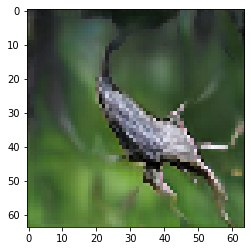

In [23]:
noise = np.random.normal(0, 1, 200)

gen_loss_hist = []
disc_loss_hist = []

for i in range(30, 40):
    gen_temp, disc_temp = train(train_imgs, 100)
    gen_loss_hist += gen_temp
    disc_loss_hist += disc_temp
    generated_image = generator.predict(np.array([noise]))[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.savefig('./results/prog-imgs/bird-gan-deeper/' + str((i+1)*100) + '.png')
    plt.show()
    generator.save_weights('./results/weights/bird-gan-deeper/gen_weights_deeper_' + str((i+1)*100) + '.h5')
    discriminator.save_weights('./results/weights/bird-gan-deeper/disc_weights_deeper_' + str((i+1)*100) + '.h5')

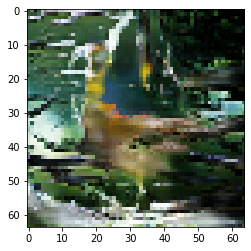

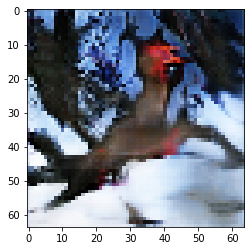

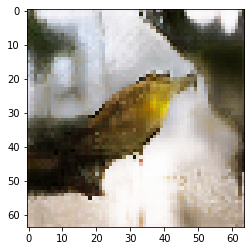

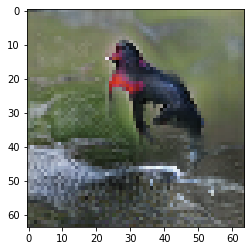

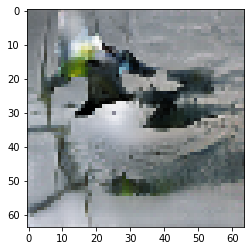

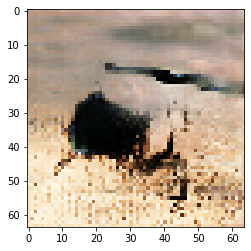

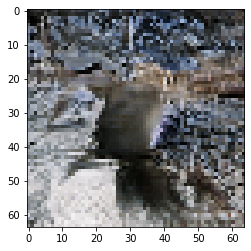

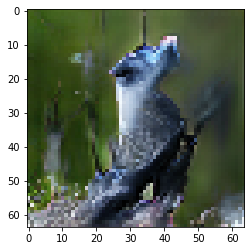

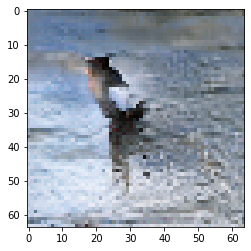

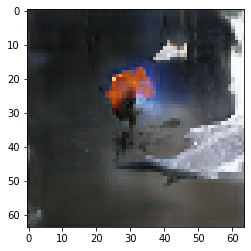

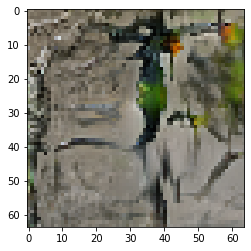

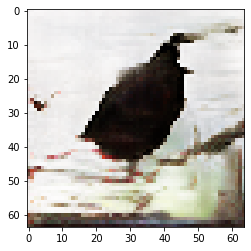

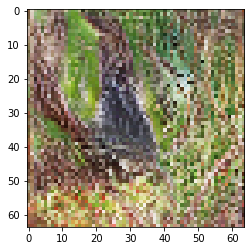

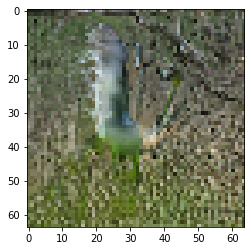

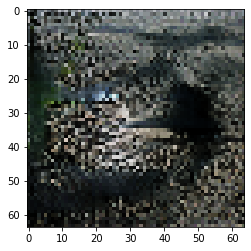

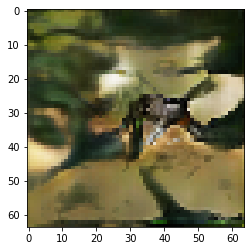

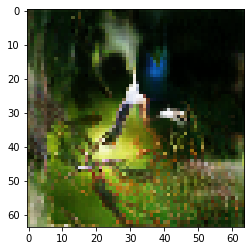

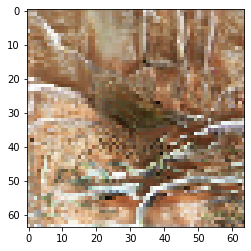

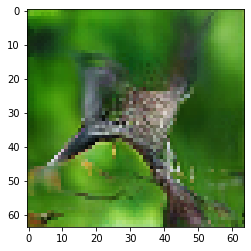

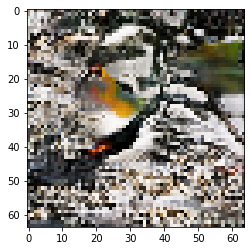

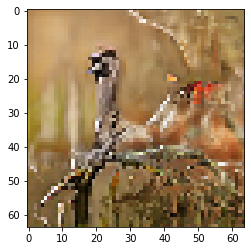

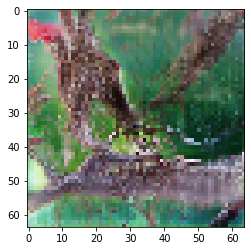

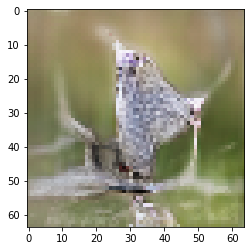

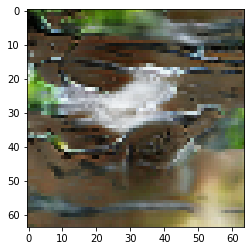

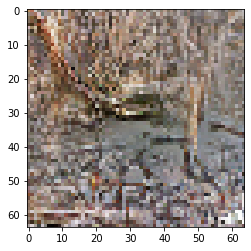

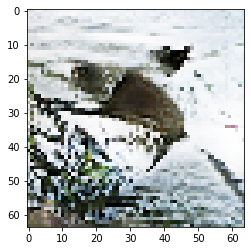

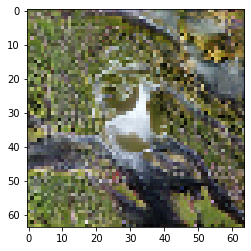

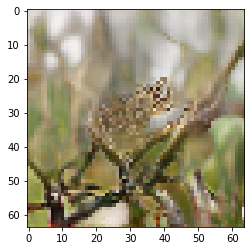

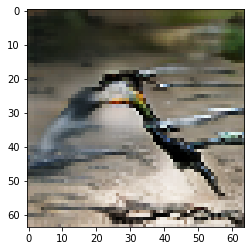

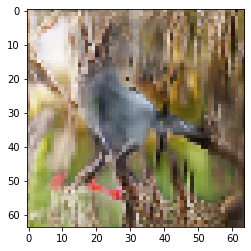

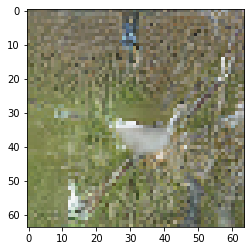

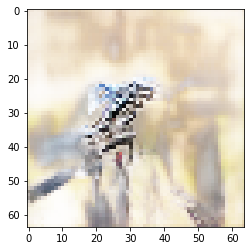

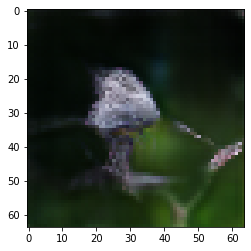

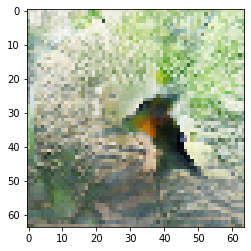

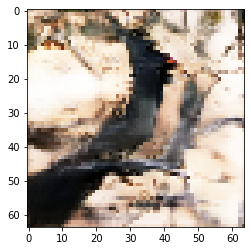

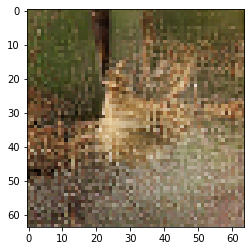

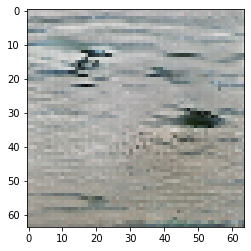

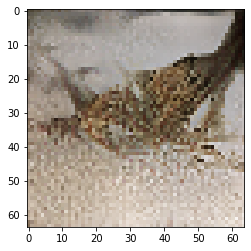

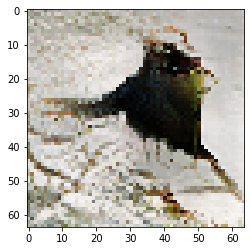

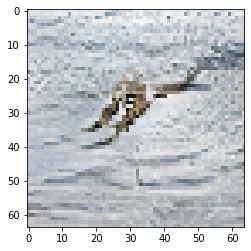

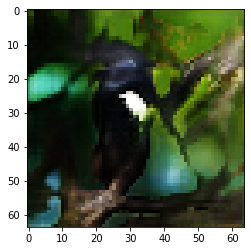

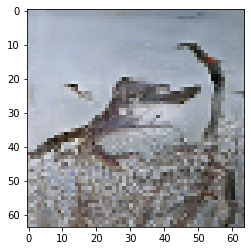

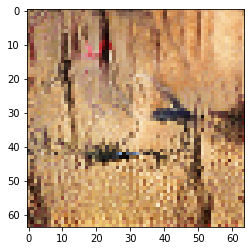

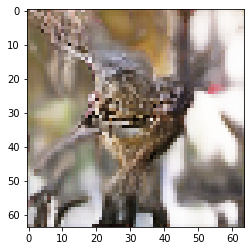

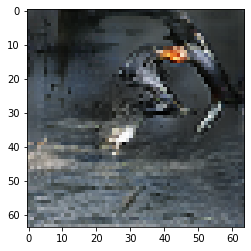

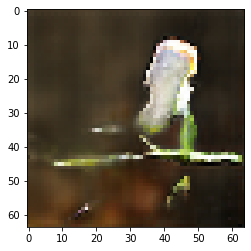

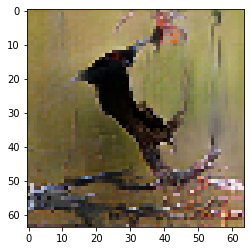

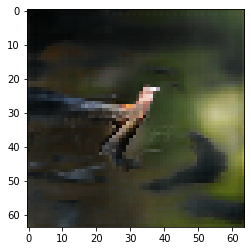

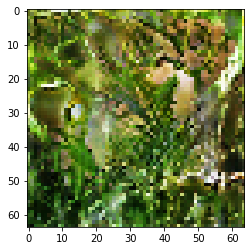

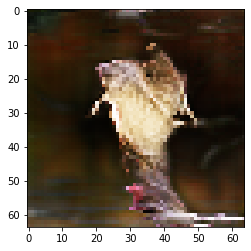

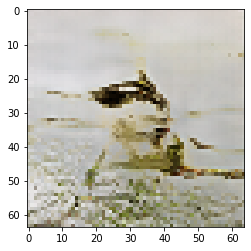

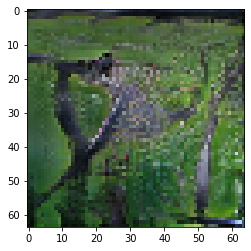

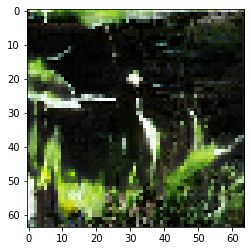

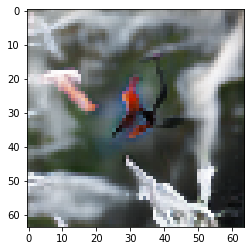

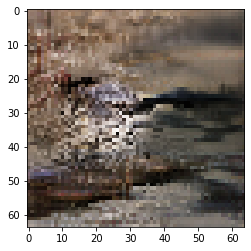

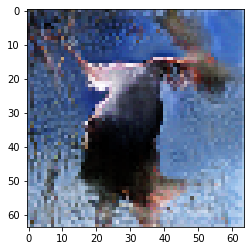

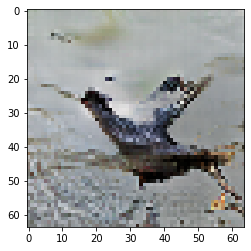

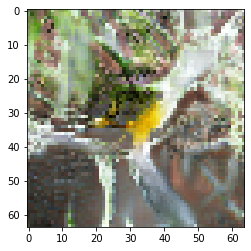

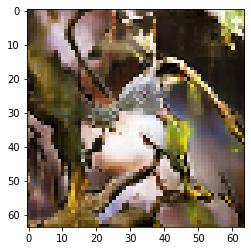

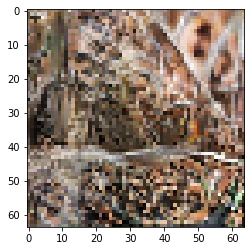

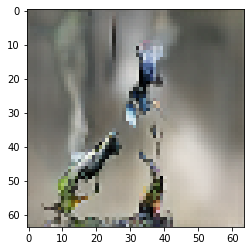

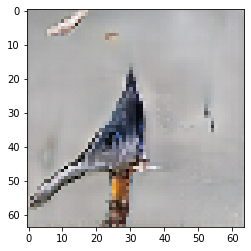

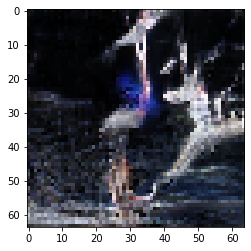

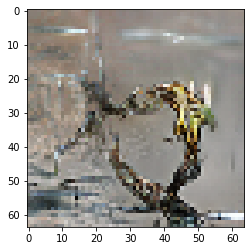

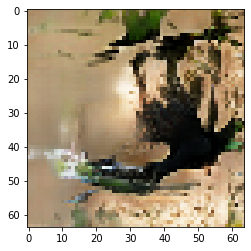

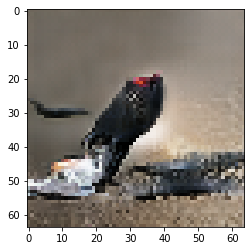

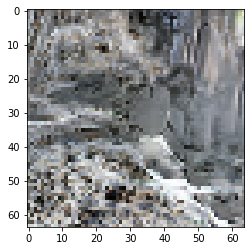

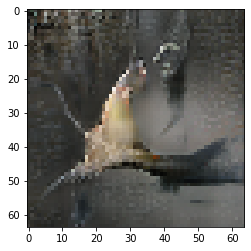

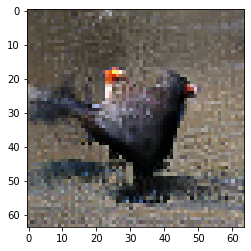

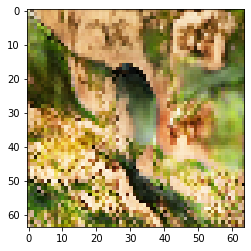

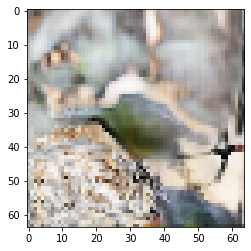

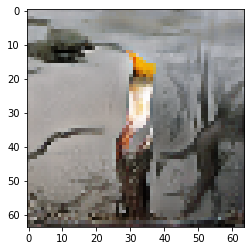

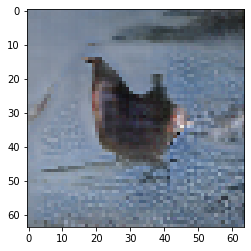

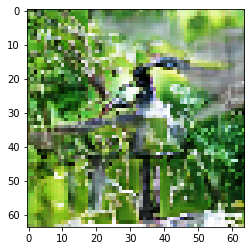

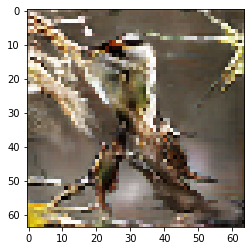

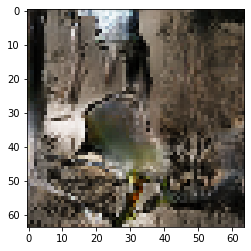

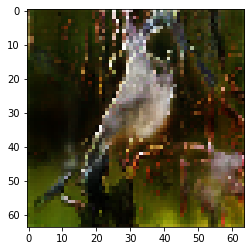

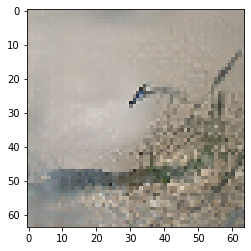

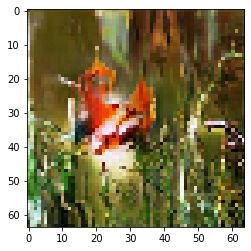

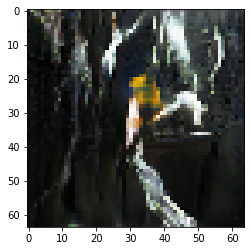

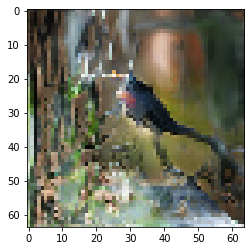

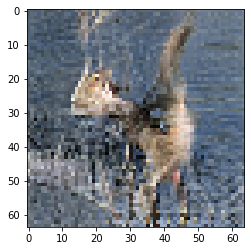

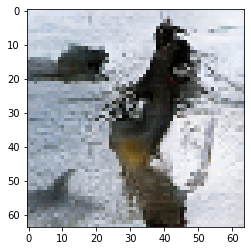

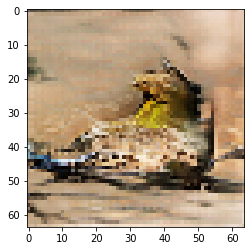

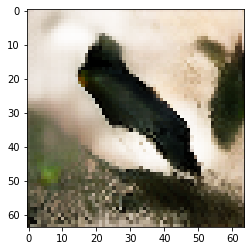

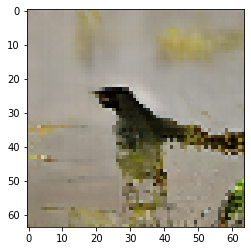

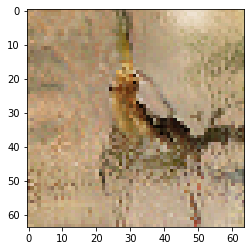

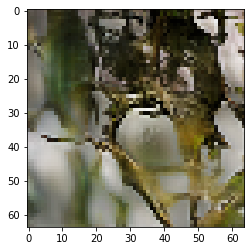

In [114]:
for i in range(100):
    noise = np.random.normal(0, 1, 200)

    generated_image = generator.predict(np.array([noise]))[0]
    plt.imshow(unnormalize_img(generated_image))
    plt.show()

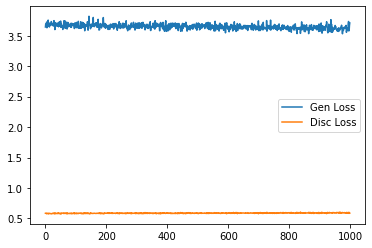

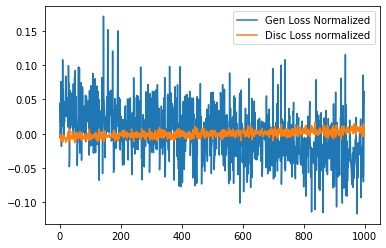

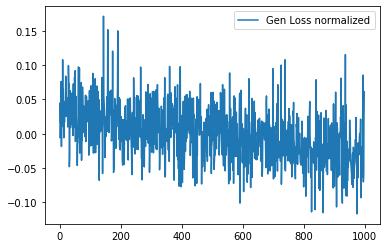

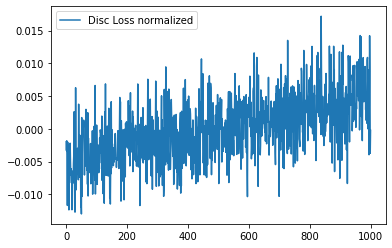

In [92]:
plt.plot(gen_loss_hist)
plt.plot(disc_loss_hist)
plt.legend(['Gen Loss','Disc Loss'])
plt.show()

plt.plot(gen_loss_hist - np.mean(gen_loss_hist))
plt.plot(disc_loss_hist - np.mean(disc_loss_hist))
plt.legend(['Gen Loss Normalized','Disc Loss normalized'])
plt.show()

plt.plot(gen_loss_hist - (np.mean(gen_loss_hist)))
plt.legend(['Gen Loss normalized'])
plt.show()

plt.plot(disc_loss_hist - np.mean(disc_loss_hist))
plt.legend(['Disc Loss normalized'])
plt.show()

In [54]:
old_gen = make_generator_model((200,))
old_gen.load_weights('./results/weights/bird-gan-deeper/gen_weights_deeper_3000.h5')

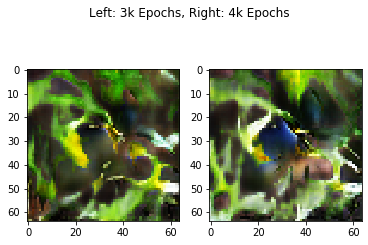

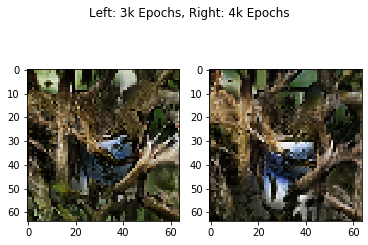

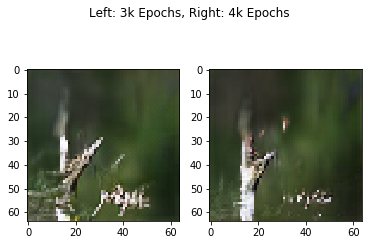

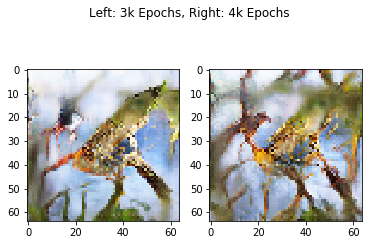

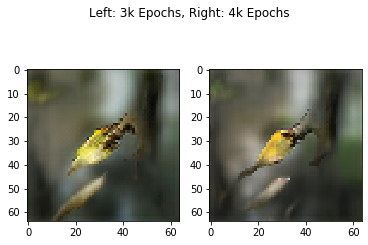

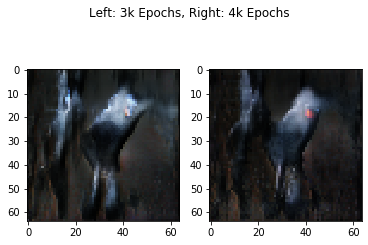

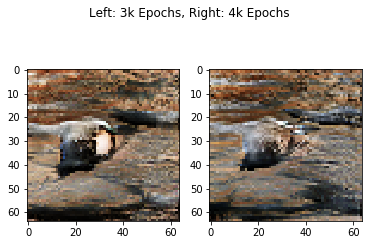

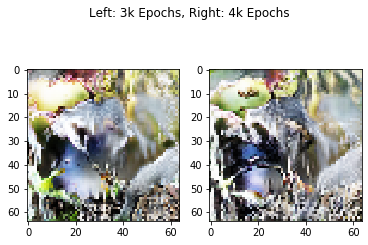

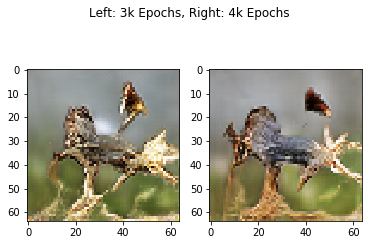

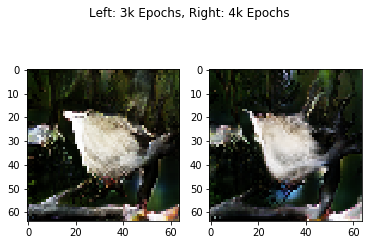

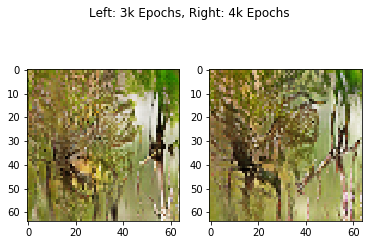

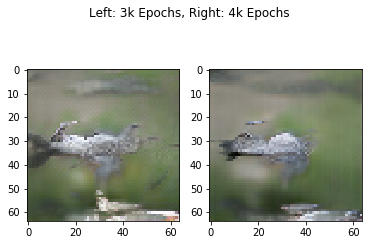

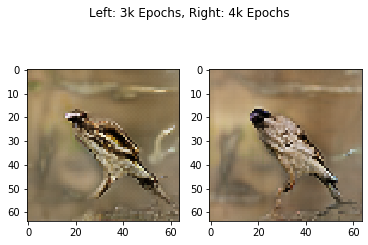

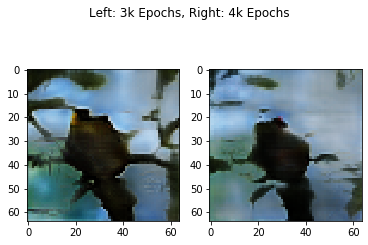

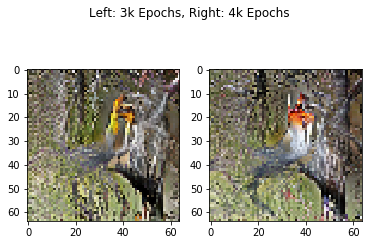

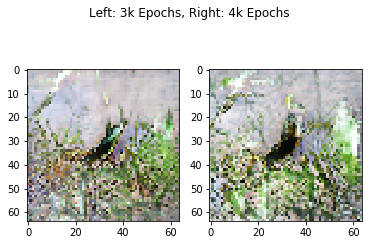

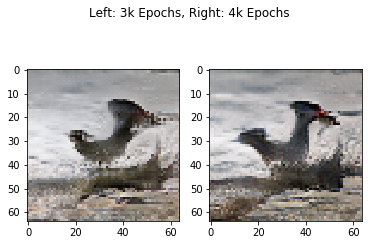

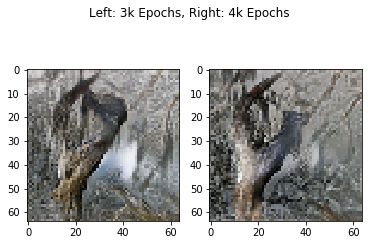

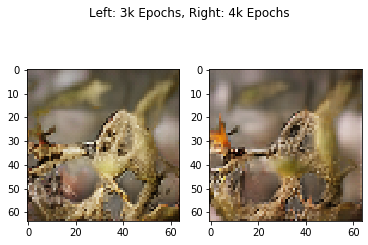

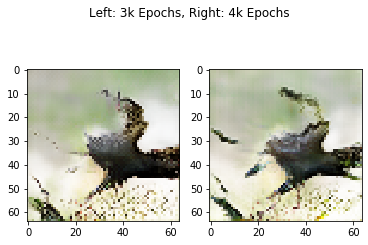

In [83]:
for i in range(20):
    noise = np.random.normal(0, 1, 200)

    generated_image_old = old_gen.predict(np.array([noise]))[0]
    generated_image = generator.predict(np.array([noise]))[0]
    f, axarr = plt.subplots(1, 2)
    f.suptitle('Left: 3k Epochs, Right: 4k Epochs')
    axarr[0].imshow(unnormalize_img(generated_image_old))
    axarr[1].imshow(unnormalize_img(generated_image))
#     plt.imshow(unnormalize_img(generated_image))
    plt.show()